In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import mode

In [2]:
# Путь к папке с атаками
base_path = "./attacks/"

combined_path = "./combined/"
os.makedirs(combined_path, exist_ok=True)

attack_folders = os.listdir(base_path)
attack_labels = {attack: idx + 1 for idx, attack in enumerate(attack_folders)}
attack_labels

{'brute-http': 1,
 'brute-ftp': 2,
 'inf-usb': 3,
 'xss': 4,
 'brute-ssh': 5,
 'inf-dropbox': 6,
 'sql-inj': 7,
 'botnet-ares': 8}

Анализ важности признаков

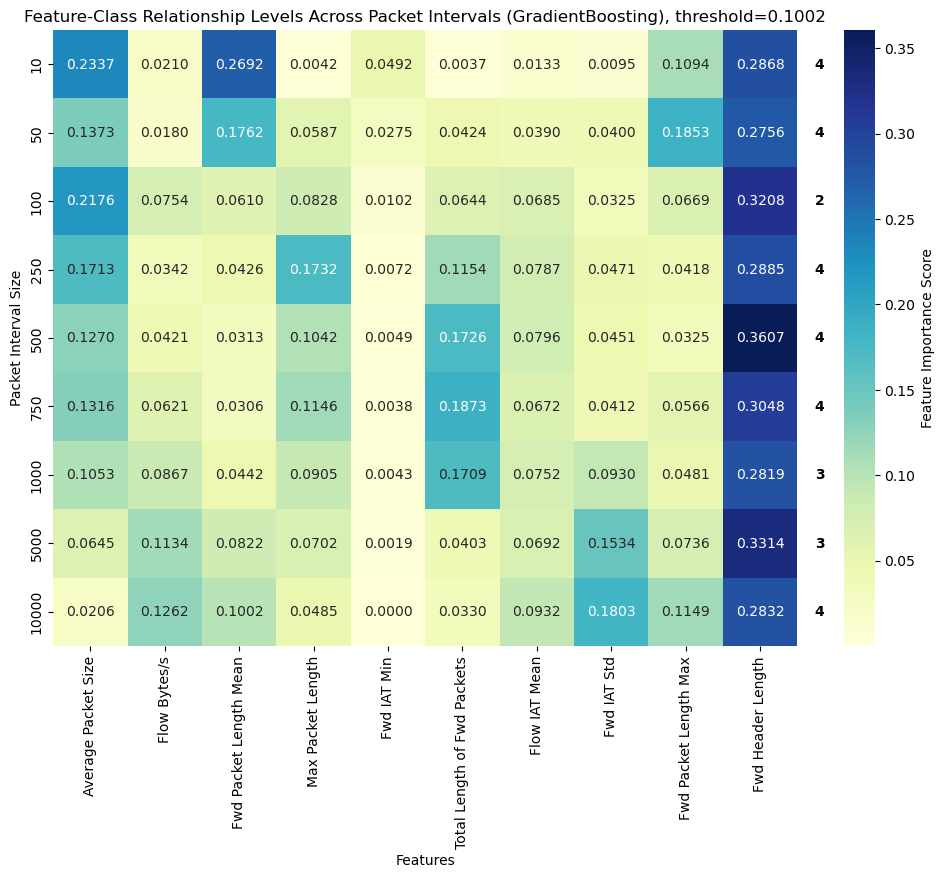

,Average Packet Size,Flow Bytes/s,Fwd Packet Length Mean,Max Packet Length,Fwd IAT Min,Total Length of Fwd Packets,Flow IAT Mean,Fwd IAT Std,Fwd Packet Length Max,Fwd Header Length,High Importance Count
10,0.233712,0.021050,0.269184,0.004229,0.049179,0.003715,0.013260,0.009542,0.109369,0.286760,4
50,0.137262,0.018026,0.176194,0.058662,0.027515,0.042397,0.038970,0.040039,0.185296,0.275638,4
100,0.217556,0.075436,0.061047,0.082785,0.010225,0.064369,0.068484,0.032496,0.066850,0.320752,2
250,0.171304,0.034159,0.042585,0.173207,0.007229,0.115428,0.078703,0.047059,0.041826,0.288499,4
500,0.127020,0.042116,0.031309,0.104208,0.004890,0.172617,0.079575,0.045135,0.032473,0.360658,4
750,0.131649,0.062106,0.030637,0.114558,0.003815,0.187348,0.067220,0.041235,0.056639,0.304793,4
1000,0.105319,0.086729,0.044165,0.090548,0.004282,0.170885,0.075178,0.092978,0.048055,0.281860,3
5000,0.064452,0.113406,0.082167,0.070181,0.001879,0.040297,0.069202,0.153382,0.073611,0.331421,3
10000,0.020609,0.126160,0.100203,0.048474,0.000005,0.032977,0.093165,0.180307,0.114942,0.283158,4


Пороговое значение важности признаков (мода): 0.1002


In [3]:
# Путь к папке с объединенными файлами
combined_path = "./combined/"

# Сбор всех значений feature_importances_ для вычисления моды
all_importances = []

for combined_file in os.listdir(combined_path):
    if combined_file.endswith(".csv"):
        # Чтение данных
        df = pd.read_csv(os.path.join(combined_path, combined_file))

        # Признаки (X) и целевая переменная (y)
        X = df.drop(columns=["Label"])
        y = df["Label"]

        # Обучение модели градиентного бустинга
        model = GradientBoostingClassifier(random_state=0)
        model.fit(X, y)

        # Важности признаков
        all_importances.extend(model.feature_importances_)

# Фильтрация значений, оставляя только значения больше 0.1
filtered_importances = [imp for imp in all_importances if imp > 0.1]

# Проверка на пустой список после фильтрации, чтобы избежать ошибок
if filtered_importances:
    # Вычисление моды среди отфильтрованных значений
    importance_threshold = mode(filtered_importances)[0]
else:
    raise ValueError(
        "Нет значений feature_importances_ выше 0.1. Проверьте данные в папке."
    )

# Сбор данных по важности признаков и числу значимых признаков для каждого размера выборки
feature_importances_data = {}

for combined_file in os.listdir(combined_path):
    if combined_file.endswith(".csv"):
        # Чтение данных
        df = pd.read_csv(os.path.join(combined_path, combined_file))

        # Признаки (X) и целевая переменная (y)
        X = df.drop(columns=["Label"])
        y = df["Label"]

        # Обучение модели градиентного бустинга
        model = GradientBoostingClassifier(random_state=0)
        model.fit(X, y)

        # Важности признаков
        importances = model.feature_importances_

        # Подсчет признаков с важностью выше порога
        high_importance_count = sum(imp > importance_threshold for imp in importances)

        # Извлечение размера выборки пакетов из названия файла
        packet_size = int(re.search(r"(\d+)_packets", combined_file).group(1))

        # Сохранение данных в словарь
        feature_importances_data[packet_size] = (importances, high_importance_count)

# Сортировка данных по длине выборки пакетов
sorted_packet_sizes = sorted(feature_importances_data.keys())

# Преобразование данных в DataFrame для тепловой карты
importance_df = pd.DataFrame(
    {
        packet_size: feature_importances_data[packet_size][0]
        for packet_size in sorted_packet_sizes
    },
    index=X.columns,
).T

# Добавление столбца с числом значимых признаков
importance_df["High Importance Count"] = [
    feature_importances_data[packet_size][1] for packet_size in sorted_packet_sizes
]

# Визуализация всех важностей признаков на одной тепловой карте
plt.figure(figsize=(12, 8))
sns.heatmap(
    importance_df.drop(
        columns=["High Importance Count"]
    ),  # исключаем столбец значимых признаков для тепловой карты
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    cbar_kws={"label": "Feature Importance Score"},
)

# Добавление аннотаций для High Importance Count рядом с каждой строкой
for idx, packet_size in enumerate(sorted_packet_sizes):
    high_count = importance_df["High Importance Count"].iloc[idx]
    plt.text(
        len(importance_df.columns) - 0.7,  # позиция по x (справа от ряда значений)
        idx + 0.5,  # позиция по y
        f"{high_count}",  # текст аннотации
        color="black",
        ha="center",
        va="center",
        fontsize=10,
        fontweight="bold",
        bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.3"),
    )

plt.xlabel("Features")
plt.ylabel("Packet Interval Size")
plt.title(
    f"Feature-Class Relationship Levels Across Packet Intervals (GradientBoosting), threshold={importance_threshold:.4f}"
)
plt.show()

# Отображение таблицы с добавленным столбцом количества значимых признаков
display(importance_df)

# Вывод порогового значения важности для справки
print(f"Пороговое значение важности признаков (мода): {importance_threshold:.4f}")